<a href="https://colab.research.google.com/github/alciopralcio/ML2024/blob/zad2/Usecase2_final_Gynter_Aleksander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importowanie bibliotek

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytywanie danych o ocenach i filmach z plików CSV

In [ ]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


# Liczba filmów Sci-Fi


In [ ]:
sci_fi_count = movies[movies['genres'].str.contains('Sci-Fi')].shape[0]
print(f"Liczba filmów Sci-Fi: {sci_fi_count}")


Liczba filmów Sci-Fi: 980


In [ ]:
print(movies.columns)


Index(['movieId', 'title', 'genres'], dtype='object')


# Utworzenie rozkładu ocen komedii dla roku 2017

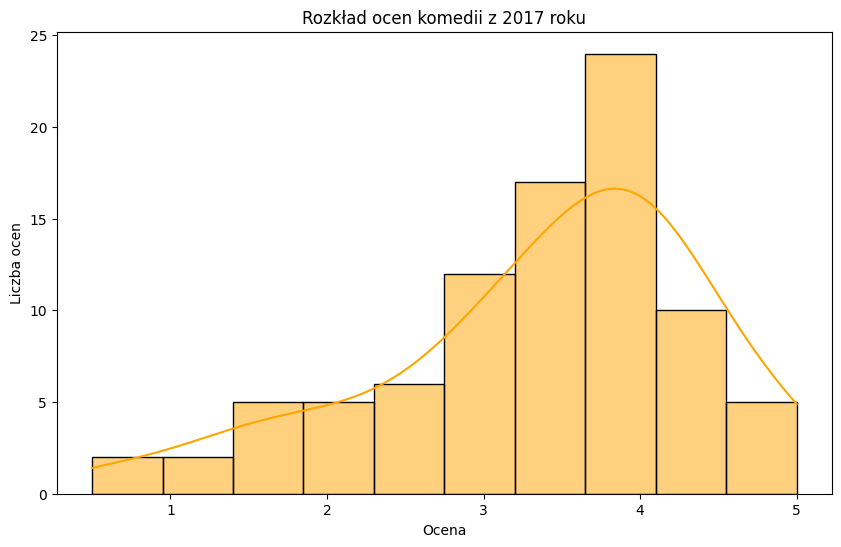

In [ ]:
# wyodrębniamy rok z kolumny 'title', przypisujemy do nowo utworzonej 'year'
movies['year'] = movies['title'].str.extract('\((\d{4})\)')

# konwersja kolumny 'year' na typ liczbowy
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# połączenie dataframe'ów: ratings i movies
combined = pd.merge(ratings, movies, on='movieId')

# wybór ocen tylko dla komedii z 2017 roku
comedy_2017 = combined[(combined['genres'].str.contains('Comedy')) & (combined['year'] == 2017)]

# utworzenie wykresu rozkładu ocen
plt.figure(figsize=(10,6))
sns.histplot(comedy_2017['rating'], bins=10, kde=True, color='orange')
plt.title('Rozkład ocen komedii z 2017 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

# Analiza filmów akcji

In [ ]:
# filmy akcji - info o ocenach
action_movies = combined[combined['genres'].str.contains('Action')]

# obliczenie średniej ocen dla wszystkich filmów akcji
average_rating_action = action_movies['rating'].mean()
print("Średnia ocen dla wszystkich filmów akcji:", average_rating_action)

# znalezienie trzech najczęściej ocenianych filmów akcji
top_action_movies = action_movies.groupby('title').size().sort_values(ascending=False).head(3)
print("\nTrzy najczęściej oceniane filmy akcji:")
for index, value in top_action_movies.items():
    print(index, "- Liczba ocen:", value)


Średnia ocen dla wszystkich filmów akcji: 3.447984331646809

Trzy najczęściej oceniane filmy akcji:
Matrix, The (1999) - Liczba ocen: 278
Star Wars: Episode IV - A New Hope (1977) - Liczba ocen: 251
Jurassic Park (1993) - Liczba ocen: 238


In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163006 sha256=a9324d3f339ac56d57f56342f5eff723774a8df155f9365a5f7558b2c0fc4c62
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# **Część II zadania - system rekomendacyjny**

In [ ]:
from surprise import SVD, KNNBaseline, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np
import time

# Sprawdzenie czy filmy "Penguins of Madagascar" i "Hobbit: The Desolation of Smaug" są w datasecie

In [ ]:
# Sprawdź, czy film "Penguins of Madagascar" jest w zestawie danych
penguins_in_dataset = 'Penguins of Madagascar' in movies['title'].values
print("Film 'Penguins of Madagascar' jest w zestawie danych:", penguins_in_dataset)

# Sprawdź, czy film "Hobbit: The Desolation of Smaug" jest w zestawie danych
hobbit_in_dataset = 'Hobbit: The Desolation of Smaug' in movies['title'].values
print("Film 'Hobbit: The Desolation of Smaug' jest w zestawie danych:", hobbit_in_dataset)


Film 'Penguins of Madagascar' jest w zestawie danych: False
Film 'Hobbit: The Desolation of Smaug' jest w zestawie danych: False


In [ ]:
# Sprawdź, ile filmów ma w tytule słowo "hobbit"
hobbit_count = movies[movies['title'].str.contains('hobbit', case=False)].shape[0]
print("Liczba filmów z 'hobbit' w tytule:", hobbit_count)

# Sprawdź, ile filmów ma w tytule słowo "penguins"
penguins_count = movies[movies['title'].str.contains('penguins', case=False)].shape[0]
print("Liczba filmów z 'penguins' w tytule:", penguins_count)


Liczba filmów z 'hobbit' w tytule: 3
Liczba filmów z 'penguins' w tytule: 4


In [ ]:
# Wyświetl pełne nazwy filmów z 'hobbit' w tytule
hobbit_movies = movies[movies['title'].str.contains('hobbit', case=False)]['title'].values
print("Filmy z 'hobbit' w tytule:")
for movie in hobbit_movies:
    print("-", movie)

# Wyświetl pełne nazwy filmów z 'penguins' w tytule
penguins_movies = movies[movies['title'].str.contains('penguins', case=False)]['title'].values
print("\nFilmy z 'penguins' w tytule:")
for movie in penguins_movies:
    print("-", movie)


Filmy z 'hobbit' w tytule:
- Hobbit: An Unexpected Journey, The (2012)
- Hobbit: The Desolation of Smaug, The (2013)
- The Hobbit: The Battle of the Five Armies (2014)

Filmy z 'penguins' w tytule:
- March of the Penguins (Marche de l'empereur, La) (2005)
- Mr. Popper's Penguins (2011)
- The Madagascar Penguins in a Christmas Caper (2005)
- Penguins of Madagascar (2014)


# ostatecznie filmy z polecenia są w zbiorze danych

# System rekomendacyjny oparty najpierw o Baseline KNN, potem o SVD


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


# Macierz sparse

In [ ]:
from scipy.sparse import csr_matrix

    # obliczamy liczbę unikalnych użytkowników i filmów
def create_sparse(df):

    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    # tworzymy mapowanie użytkowników i filmów na indeksy oraz odwrotne mapowanie indeksów na użytkowników i filmy
    user_mapper = dict(zip(np.unique(df["userId"]), range(M)))
    movie_mapper = dict(zip(np.unique(df["movieId"]), range(N)))
    user_inv_mapper = {v: k for k, v in user_mapper.items()}
    movie_inv_mapper = {v: k for k, v in movie_mapper.items()}

    # tworzymy listy indeksów użytkowników i filmów
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    # tworzymy rzadką macierz używając biblioteki csr_matrix
    X = csr_matrix((df["rating"], (user_index, movie_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

# Knn - definicja i implementacja

In [ ]:

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    # transponujemy macierz X, aby móc wykonywać operacje na kolumnach (filmach)
    X = X.T

    # inicjalizujemy listę identyfikatorów sąsiadów
    neighbour_ids = []

    # pobieramy indeks filmu na podstawie jego identyfikatora
    movie_ind = movie_mapper[movie_id]

    # następnie pobieramy wektor cech filmu
    movie_vec = X[movie_ind]

    # jeśli movie_vec jest tablicą NumPy, zmieniamy jej kształt na (1, -1)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)

    # następnie inicjalizujemy algorytm kNN
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)

    # dopasowujemy model kNN do macierzy X
    kNN.fit(X)

    # szukamy k najbliższych sąsiadów dla danego filmu
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)

    # dodajemy identyfikatory sąsiadów do listy, pomijając pierwszy element (ten sam film)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])

    neighbour_ids.pop(0)  # usuwamy pierwszy element (ten sam film)

    return neighbour_ids


In [ ]:
# dodajemy brakujące biblioteki (surprise)
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBaseline

# wczytujemy dane
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# dokonujemy podziału danych na zbiór treningowy i testowy
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# inicjalizujemy model KNNBaseline przy jednoczesnym ograniczeniu liczby iteracji
knn_algorithm = KNNBaseline(verbose=True, n_epochs=10)

# trenujemy go
knn_algorithm.fit(trainset)

# ocena na biorze testowym
predictions = knn_algorithm.test(testset)

# wyświetlenie kilku przykładowych predykcji
for pred in predictions[:5]:
    print(pred)

# obliczenie błędów na zbiorze testowym
accuracy.rmse(predictions)
accuracy.mae(predictions)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 140        item: 6765       r_ui = 3.50   est = 3.20   {'actual_k': 7, 'was_impossible': False}
user: 603        item: 290        r_ui = 4.00   est = 4.17   {'actual_k': 9, 'was_impossible': False}
user: 438        item: 5055       r_ui = 4.00   est = 2.78   {'actual_k': 5, 'was_impossible': False}
user: 433        item: 164179     r_ui = 5.00   est = 3.78   {'actual_k': 21, 'was_impossible': False}
user: 474        item: 5114       r_ui = 4.00   est = 3.32   {'was_impossible': False}
RMSE: 0.8806
MAE:  0.6728


0.6728441283432253

# SVD - definicja i implementacja

In [ ]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise import SVD

# wczytanie danych
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# podział danych - zbiór treningowy i testowy
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# inicjalizacja modelu
svd_algorithm = SVD(verbose=True, n_epochs=10)  # Ograniczenie liczby iteracji i zwiększenie wartości verbose

# trenowanie modelu
svd_algorithm.fit(trainset)

# ocena modelu na zbiorze testowym
predictions = svd_algorithm.test(testset)

# wyświetlenie kilku przykładowych predykcji
for pred in predictions[:5]:
    print(pred)

# obliczenie błędów na zbiorze testowym
accuracy.rmse(predictions)
accuracy.mae(predictions)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
user: 140        item: 6765       r_ui = 3.50   est = 3.37   {'was_impossible': False}
user: 603        item: 290        r_ui = 4.00   est = 3.70   {'was_impossible': False}
user: 438        item: 5055       r_ui = 4.00   est = 3.37   {'was_impossible': False}
user: 433        item: 164179     r_ui = 5.00   est = 3.52   {'was_impossible': False}
user: 474        item: 5114       r_ui = 4.00   est = 3.36   {'was_impossible': False}
RMSE: 0.8875
MAE:  0.6843


0.6842760271178144

# Biorąc pod uwagę MAE i RMSE, przed hiperparametryzacją różnice między modelami wydają się dość niewielkie
#KNN:
RMSE: 0.8806
MAE: 0.6728
#SVD:
RMSE: 0.8875
MAE: 0.684




# Przejdźmy do hiperparametryzacji

In [ ]:
from surprise.model_selection import GridSearchCV

# Utwórz siatkę parametrów dla KNNBaseline
param_grid_knn = {'k': [2, 3, 4, 5, 6]}  # wartości sąsiadów od 2 do 6

# Utwórz siatkę parametrów dla SVD
param_grid_svd = {'n_factors': [50, 100, 150]}  # przykładowe wartości liczby cech

# inicjalizacja obiektów GridSearchCV dla obu modeli
grid_search_knn = GridSearchCV(KNNBaseline, param_grid_knn, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# optymalizacja parametrów dla obu modeli
grid_search_knn.fit(data)
grid_search_svd.fit(data)

#  najlepsze wyniki dla obu modeli
print("Najlepsze wyniki dla KNNBaseline:")
print(grid_search_knn.best_score['rmse'])
print(grid_search_knn.best_params['rmse'])
print("\nNajlepsze wyniki dla SVD:")
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])


Najlepsze wyniki dla KNNBaseline:
0.8950389645241096
{'k': 6}

Najlepsze wyniki dla SVD:
0.8703788117608475
{'n_factors': 50}


# Najniższy błąd RMSE lub MAE w KNN jest dla 6 sąsiadów, z kolei w SVD optymalny był wybór 50 czynników w rozkładzie macierzy użytkowników i przedmiotów dla tych danych

In [ ]:
from surprise.model_selection import cross_validate

# inicjalizacja ostatecznych modeli z optymalnymi parametrami
best_knn = grid_search_knn.best_estimator['rmse']
best_svd = grid_search_svd.best_estimator['rmse']

# ocena modeli za pomocą walidacji krzyżowej
knn_results = cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
svd_results = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# wyświetlenie wyników
print("Wyniki KNNBaseline:")
for key, value in knn_results.items():
    print(key, ':', round(np.mean(value), 4))

print("\nWyniki SVD:")
for key, value in svd_results.items():
    print(key, ':', round(np.mean(value), 4))


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9080  0.8912  0.8898  0.8953  0.8896  0.8948  0.0069  
MAE (testset)     0.6950  0.6820  0.6848  0.6846  0.6808  0.6854  0.0050  
Fit time          1.19    1.10    0.59    0.58    0.61    0.81    0.28    
Test time         3.18    2.71    1.13    1.10    1.12    1.85    0.91    
Evaluating RMSE, MAE of algorithm SVD on 5 

# **Model SVD osiągnął lepsze wyniki niż KNNBaseline, przy jednocześnie krótszym czasie uczenia i predykcji.**

# Różnice te jednak nie są na tyle znaczne, by mówić że SVD nadaje się do rekomendacji bardziej - poniżej przykład użycia KNN Baseline do znalezienia rekomendacji po obejrzeniu dwóch filmów

In [ ]:
# Pobieramy identyfikatory filmów na podstawie ich tytułów
penguins_movie_id = movies[movies['title'].str.contains('Penguins of Madagascar')]['movieId'].values[0]
hobbit_movie_id = movies[movies['title'].str.contains('Hobbit: The Desolation of Smaug')]['movieId'].values[0]

# Generujemy rekomendacje dla filmu "Penguins of Madagascar"
penguins_recommendations = find_similar_movies(penguins_movie_id, X, movie_mapper, movie_inv_mapper, k=5)

# Generujemy rekomendacje dla filmu "Hobbit: The Desolation of Smaug"
hobbit_recommendations = find_similar_movies(hobbit_movie_id, X, movie_mapper, movie_inv_mapper, k=5)

# Wyświetlamy rekomendacje
print("Rekomendacje dla filmu Penguins of Madagascar:")
for movie_id in penguins_recommendations:
    print(movies[movies['movieId'] == movie_id]['title'].values[0])

print("\nRekomendacje dla filmu Hobbit: The Desolation of Smaug:")
for movie_id in hobbit_recommendations:
    print(movies[movies['movieId'] == movie_id]['title'].values[0])


Rekomendacje dla filmu Penguins of Madagascar:
Sing (2016)
Home (2015)
Kung Fu Panda: Secrets of the Masters (2011)
Dave Chappelle: For What it's Worth (2004)

Rekomendacje dla filmu Hobbit: The Desolation of Smaug:
The Hobbit: The Battle of the Five Armies (2014)
Hobbit: An Unexpected Journey, The (2012)
Iron Man 3 (2013)
Captain America: The Winter Soldier (2014)
